# Wykrywanie anomalii sieciowy

## LAB 03 Sieci neuronowe (nn) &nbsp; | &nbsp; *Neural Networks (nn)*

- Nieliniowości w modelu  &nbsp; | &nbsp; *Nonlinearities in the model*
- Przeuczenie  &nbsp; | &nbsp; *Overfitting*
- Regularyzacja  &nbsp; | &nbsp; *Regularization*

## Plan
|  | | |
| -------- | -------|---- |
| Wprowadzenie | *Introduction* | 15 min |
| nn | nn |20 min |
| Przeuczenie | *Overfitting*  | 20 min |
| Regularyzacja | *Regularization* | 25 min |
| Podsumowanie | *Summary* | 10 min|

In [ ]:
#@title Required libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

import jax
import jax.numpy as jnp
import functools as ft
from jax.example_libraries.optimizers import adam
from jax.example_libraries import stax

# Uniwersalny aproksymator  &nbsp; | &nbsp; *Universal approximator*
Wygenerujemy funkcję &nbsp; | &nbsp; *Let's generate a function*



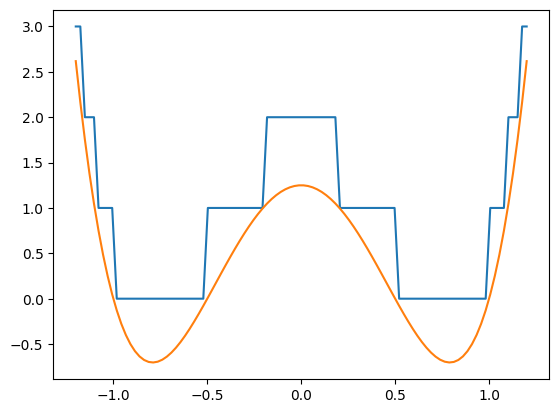

In [ ]:
def stair_case_function(x):
    p = jnp.poly(-jnp.array([-1,-0.5,0.5,1]))
    smooth = jnp.polyval(p, x)/0.2
    return jnp.ceil(smooth),smooth

x = np.linspace(-1.2,1.2,100)
y,ysmooth = stair_case_function(x)

sns.lineplot(x=x,y=y)
sns.lineplot(x=x,y=ysmooth)
plt.show()

In [ ]:
def init_nn(key, shapes):
    params = [ dict(
        w=0.1*jax.random.normal(key,shape),
        b=jnp.zeros(shape[-1]),
    ) for shape in shapes]
    return params

@jax.jit
def apply_nn(theta:dict,x:jnp.ndarray):
    for i,layer in enumerate(theta):
        if i != len(layer)-1:
            x = jax.nn.tanh(x@layer['w'] + layer['b'])
        else:
            x = x@layer['w'] + layer['b']
    return x

@jax.jit
def mse(params,x,y):
    nn_out = apply_nn(params,x)
    return jnp.mean(jnp.square(y-nn_out))

In [ ]:
np.random.seed(42)
xtrain = np.random.uniform(low=x[0],high=x[-1],size=(256,1))
ytrain,_ = stair_case_function(xtrain)

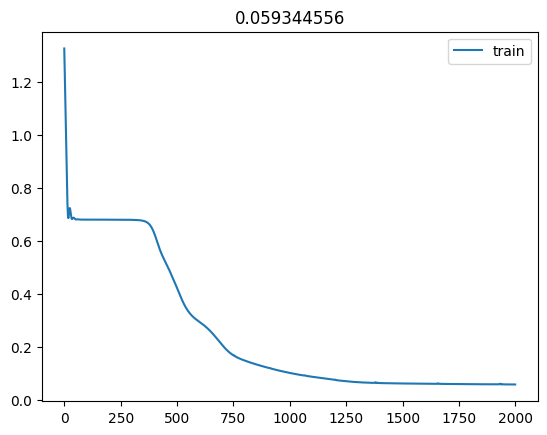

In [ ]:
k = jax.random.PRNGKey(42)

params  = init_nn(k,[(xtrain.shape[1],16),(16,ytrain.shape[1])])
losses = []

grad_loss = jax.jit(jax.grad(mse))

opt_init, opt_update, get_params = adam(0.01)
opt_state = opt_init(params)

for i in range(2000):
    grads = grad_loss(params, xtrain, ytrain)
    opt_state = opt_update(i, grads, opt_state)
    params = get_params(opt_state)
    losses.append(mse(params,xtrain,ytrain))

plt.plot(losses,label='train')
plt.title(str(losses[-1]))
plt.legend();


Zobaczmy jak wygląda dopasowanie i przy okazji pochodna

*Let's see what the matching and the derivative look like*

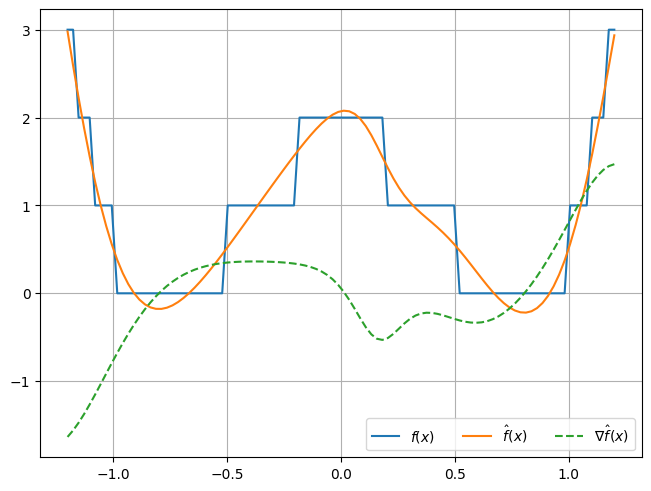

In [ ]:
@jax.jit
def grad_fn(params, x):
    @ft.partial(jax.vmap, in_axes=(0, None))
    @jax.grad
    def fn(x, params):
        return apply_nn(params, jnp.expand_dims(x, 0))[0,0]

    return fn(x, params)


yhat = apply_nn(params,x[..., np.newaxis])
grads = grad_fn(params,x[..., np.newaxis])

fig, ax = plt.subplots( constrained_layout=True)

sns.lineplot(x=x, y=y, label='$f(x)$', ax=ax)
sns.lineplot(x=x, y=yhat[:,0], label='$\hat f(x)$', ax=ax)
ax = sns.lineplot(x=x, y=0.1 * grads[:,0], label=r'$\nabla \hat f(x)$', ax=ax)
ax.lines[2].set_linestyle("--")
plt.legend(ncol=3)
plt.grid(True)
plt.show()

# Mini biblioteka  &nbsp; | &nbsp; *Mini library*

- Strukture sieci mozna kodować w naszym wzorcu funkcyjnym `init` i `update`jednak w miare dodawania mechanizmów implementacja się komplikuje.

  - *The network structure can be encoded in our `init` and `update` function patterns, but as mechanisms are added, the implementation becomes more complicated.*

- JAX dostarcza bardzo prostą bibliotekę `stax` która działa dokładnie jak nasze proste modele a pokazuje tez uniwersalne API w bibliotekach do uczenia maszynowego.  
  - *JAX provides a very simple `stax` library that works exactly like our simple models and also shows a universal API in machine learning libraries.*

- Poniżej sprawdzimy jak wygląda api w `stax` i rozbudujemy je o kilka przydanych funkcji.
  - *Below we will check what the API in `stax` looks like and expand it with some useful functions.*

- Najwazniejsza funckjonalość `stax` to kombinarory pozwalające łączyć moduły
  - *The most important feature of `stax` are combinators that allow you to connect modules*

```python
nn = stax.serial(
    stax.Dense(16),
    stax.Tanh,
    stax.Dense(1)
)
```







In [ ]:
@jax.jit
def mse(y,yhat):
    #nn_out = apply_nn(params,x)
    return jnp.mean(jnp.square(y-yhat))

@jax.jit
def cross_entropy(y,logits):
    #nn_out = apply_nn(params,x)
    lp = jax.nn.log_softmax(logits)
    return -jnp.mean(lp*y)



@ft.partial(jax.jit, static_argnames=('n'))
def confusion_matrix(labels, predictions, n):
    '''
    :param labels: Prawdziwe etykiety
    :param predictions: Przeidywane etykiety
    :param n: liczba różnych etykiet
    :return: macierz pomyłek, w wierszach prawdziwe etykiety, w kolumnie predykcje
    '''
    cm, _ = jax.lax.scan(
        lambda carry, pair: (carry.at[pair].add(1), None),
        jnp.zeros((n,n), dtype=jnp.uint32),
        (labels, predictions)
        )
    return cm

@jax.jit
def classification_summary(cm):
    return dict(
        acc=jnp.sum(jnp.diag(cm))/jnp.sum(cm),
        tpr=jnp.diag(cm)/jnp.sum(cm, axis=1),
        ppv=jnp.diag(cm)/jnp.sum(cm, axis=0)
    )

## test działania &nbsp; | &nbsp; *functional test*

In [ ]:
k = jax.random.PRNGKey(43)

d = stax.Dense(4)
print(d)

init,apply = d
_,params = init(k,(4,3))
x = np.random.normal(size=(8,3))
apply(params,x )

(<function Dense.<locals>.init_fun at 0x78aadc346710>, <function Dense.<locals>.apply_fun at 0x78aadc3467a0>)


Array([[-0.07110156,  0.07300892, -0.02990044, -0.29552162],
       [-0.14411348, -0.01644426, -0.37782145,  0.06025977],
       [-0.05995309,  0.5680605 ,  0.74184036, -1.1240366 ],
       [-1.0259044 ,  0.7576314 , -1.6598871 ,  0.26218775],
       [-0.19510972,  0.63130033,  0.47662058, -1.1067029 ],
       [-2.2590108 ,  3.9937727 ,  0.01565078, -4.778653  ],
       [-0.4780556 ,  0.94784427,  0.21032621, -1.4695444 ],
       [-0.6723848 ,  0.63322484, -0.8697819 , -0.10721435]],      dtype=float32)

# Diamenty  | &nbsp; *Diamonds*

Dalej pracujemy na danych o diamentach

*We continue to work on diamond data*


In [ ]:
#@title get data
!gdown  https://drive.google.com/uc?id=1c4-h7TLRaDmijstDIFD093to9uZwYA6F

Downloading...
From: https://drive.google.com/uc?id=1c4-h7TLRaDmijstDIFD093to9uZwYA6F
To: /content/diamonds.csv
100% 2.45M/2.45M [00:00<00:00, 204MB/s]


In [ ]:
diamonds = pd.read_csv('diamonds.csv')
display(diamonds)
print('orig size:', len(diamonds))
#diamonds = diamonds.sample(frac=1.0)
print('sample size:', len(diamonds))

clarity = pd.get_dummies(diamonds['clarity'])
color = pd.get_dummies(diamonds['color'])
diamonds.drop(['color' , 'clarity'], axis=1, inplace=True)

x = diamonds.drop(['cut'],axis =1 ).to_numpy()
y = pd.get_dummies(diamonds.cut).to_numpy()

x = (x-np.mean(x,0))/np.std(x,0)  # x~N(0,1)
x = jnp.concatenate([x,color.to_numpy(), clarity.to_numpy()], axis=1)

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
53935,0.72,Ideal,D,SI1,60.8,57.0,2757,5.75,5.76,3.50
53936,0.72,Good,D,SI1,63.1,55.0,2757,5.69,5.75,3.61
53937,0.70,Very Good,D,SI1,62.8,60.0,2757,5.66,5.68,3.56
53938,0.86,Premium,H,SI2,61.0,58.0,2757,6.15,6.12,3.74


orig size: 53940
sample size: 53940


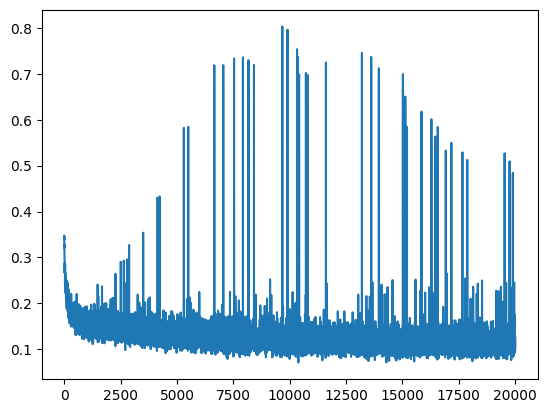

In [ ]:
batch_size = 128
steps = 20000
learning_rate = 0.001

k = jax.random.PRNGKey(42)

nn = stax.serial(
    stax.Dense(128),
    stax.Relu,
    stax.Dense(y.shape[1])
)

init_nn, apply_nn = nn
opt_init, opt_update, get_params = adam(learning_rate)

@jax.jit
def step(i, opt_state, x,y):
  params = get_params(opt_state)

  def loss(params,x,y):
      logits = apply_nn(params,x)
      return cross_entropy(y,logits)

  g = jax.grad(loss)(params, x,y)
  opt_state = opt_update(i, g, opt_state)
  step_loss = loss(get_params(opt_state),x,y)
  return opt_state, step_loss

_,params  = init_nn(k,(batch_size,x.shape[1]))
opt_state = opt_init(params)

losses = []

for i in range(steps):
    idx = np.random.randint(0,x.shape[0],size=batch_size)
    bx = x[idx,...]
    by = y[idx,...]

    opt_state, step_loss = step(i, opt_state,bx,by)
    losses.append(step_loss)

plt.plot(losses)

{'acc': Array(0.7805895, dtype=float32), 'ppv': Array([0.85910225, 0.6780488 , 0.8235786 , 0.82962686, 0.6539862 ],      dtype=float32), 'tpr': Array([0.85590065, 0.651651  , 0.9141107 , 0.7979842 , 0.5648899 ],      dtype=float32)}


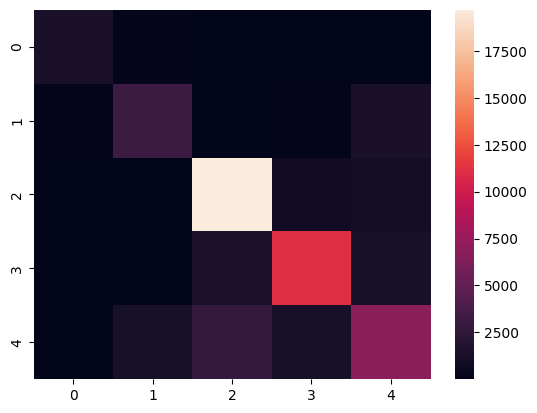

In [ ]:
c = apply_nn(get_params(opt_state), x)
c = jnp.argmax(c, 1)

cm=confusion_matrix(jnp.argmax(y,1),c,5)
sns.heatmap(cm, label=True)
print(classification_summary(cm))

# Walidacja | &nbsp; *Validation*

## Zadanie 1 | &nbsp; *Task 1*

Przetestować model na nowych danych

*Test the model on new data*

In [ ]:
batch_size=128
steps=20000
learning_rate=0.001
train_split=int(0.7*x.shape[0])

k = jax.random.PRNGKey(42)

nn = stax.serial(
    stax.Dense(128),
    stax.Relu,
    stax.Dense(y.shape[1])
)

init_nn,apply_nn = nn
opt_init, opt_update, get_params = adam(learning_rate)



@jax.jit
def step(i, opt_state, x,y):
  params = get_params(opt_state)

  def loss(params,x,y):
      logits = apply_nn(params,x)
      return cross_entropy(y,logits)

  g = jax.grad(loss)(params, x,y)
  opt_state = opt_update(i, g, opt_state)
  step_loss = loss(get_params(opt_state),x,y)
  return opt_state, step_loss

_,params  = init_nn(k,(batch_size,x.shape[1]))
opt_state = opt_init(params)

losses=[]
test_losses=[]

@jax.jit
def test_loss(opt_state,x,y):
    params = get_params(opt_state)
    logits = apply_nn(params,x)
    return cross_entropy(y,logits)

for i in range(steps):
    idx = np.random.randint(0,train_split,size=batch_size)
    bx = x[idx,...]
    by = y[idx,...]

    opt_state, step_loss = step(i, opt_state,bx,by)
    losses.append(step_loss)

    tx = x[train_split:,...]
    ty = y[train_split:,...]

    test_losses.append(test_loss(opt_state,tx,ty))

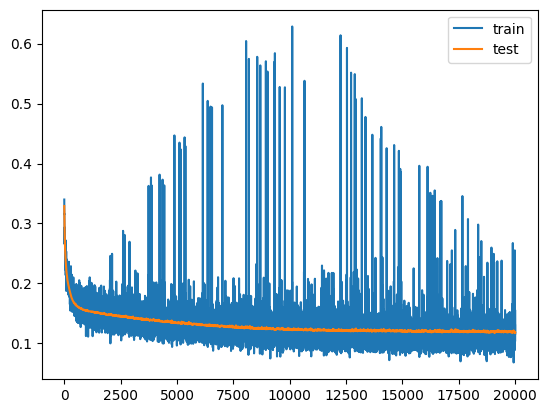

In [ ]:
plt.plot(losses,label='train')
plt.plot(test_losses,label='test')
plt.legend()

# Przeuczenie  &nbsp; | &nbsp; *Overfitting*

Przeuczenie występuje, gdy mdoel dziła gorzej na nowych danych niż na danych treningowych.
Najczęściej wynika z małej liczby danych.

*Overfitting occurs when mdoel performs worse on new data than on training data.
Most often it results from a small amount of data.*

## Zadanie 2  &nbsp; | &nbsp; *Task 2*

Zmniejszyć zbiór treningowy do kilkuset przykładów

*Reduce the training set to a few hundred examples*

0.03328526


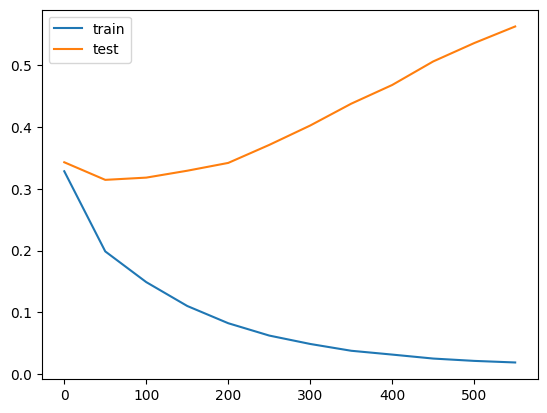

In [ ]:
batch_size=32
steps=600
train_split=int(0.001*x.shape[0])


k = jax.random.PRNGKey(42)

nn = stax.serial(
    stax.Dense(128),
    stax.Relu,
    stax.Dense(y.shape[1])
)

init_nn,apply_nn = nn
opt_init, opt_update, get_params = adam(learning_rate)

@jax.jit
def step(i, opt_state, x,y):
  params = get_params(opt_state)

  def loss(params,x,y):
      logits = apply_nn(params,x)
      return cross_entropy(y,logits)

  g = jax.grad(loss)(params, x,y)
  opt_state = opt_update(i, g, opt_state)
  step_loss = loss(get_params(opt_state),x,y)
  return opt_state, step_loss

_,params  = init_nn(k,(batch_size,x.shape[1]))
opt_state = opt_init(params)

losses=[]
test_losses=[]
train_steps=[]

for i in range(steps):
    idx = np.random.randint(0,train_split,size=batch_size)
    bx = x[idx,...]
    by = y[idx,...]

    opt_state, step_loss = step(i, opt_state,bx,by)

    if i % 50 == 0:
        tx = x[train_split:,...]
        ty = y[train_split:,...]
        test_losses.append(test_loss(opt_state,tx,ty))
        train_steps.append(i)
        losses.append(test_loss(opt_state,x[:train_split,...],y[:train_split,...]))

plt.plot(train_steps,losses,label='train')
plt.plot(train_steps,test_losses,label='test')
plt.legend()

print(losses[-1]/test_losses[-1])

# Regularyzacja &nbsp;| &nbsp; *Regularization*

## Zadanie 3  &nbsp;| &nbsp; *Task 3*

Przeuczenie ograniczamy regularyzując model.

* *We reduce overfitting by regularizing the model.*


Zmodyfikować funkcje kosztu tak aby zawierała czynnik proporcjonalny do $\sum_{ijk}w_{ijk}^2$


* *Modify the cost function to include a factor proportional to $\sum_{ijk}w_{ijk}^2$*

1.0204664


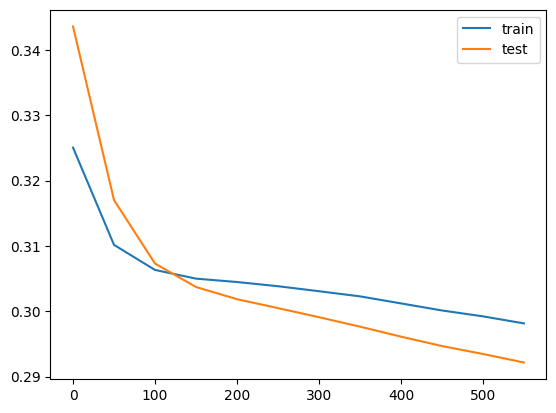

In [ ]:

batch_size=32
steps=600
train_split=int(0.01*x.shape[0])


k = jax.random.PRNGKey(42)

nn = stax.serial(
    stax.Dense(128),
    stax.Relu,
    stax.Dense(y.shape[1])
)

init_nn,apply_nn = nn
opt_init, opt_update, get_params = adam(learning_rate)

@jax.jit
def step(i, opt_state, x,y):
  params = get_params(opt_state)

  def loss(params,x,y):
      logits = apply_nn(params,x)
      ce = cross_entropy(y,logits)
      l2 = sum([0.8*jnp.sum(jnp.square(layer[0])) for layer in params if len(layer)>0])
      return ce + l2

  g = jax.grad(loss)(params, x,y)
  opt_state = opt_update(i, g, opt_state)
  step_loss = loss(get_params(opt_state),x,y)
  return opt_state, step_loss

_,params  = init_nn(k,(batch_size,x.shape[1]))
opt_state = opt_init(params)

losses = []
test_losses=[]
train_steps=[]

for i in range(steps):
    idx = np.random.randint(0,train_split,size=batch_size)
    bx = x[idx,...]
    by = y[idx,...]

    opt_state, step_loss = step(i, opt_state,bx,by)

    if i % 50 == 0:
        tx = x[train_split:,...]
        ty = y[train_split:,...]
        test_losses.append(test_loss(opt_state,tx,ty))
        train_steps.append(i)
        losses.append(test_loss(opt_state,x[:train_split,...],y[:train_split,...]))

plt.plot(train_steps,losses,label='train')
plt.plot(train_steps,test_losses,label='test')
plt.legend()

print(losses[-1]/test_losses[-1])

# Bonus: macierz pomyłek   &nbsp;| &nbsp; *confusion matrix*

Macierz pomyłek zawiera zliczenie według prawdziwej przewidywanej klasy.

- *The confusion matrix contains a count by the true predicted class.*

W implementacji dostarczonej w tym notatniku każdy wiersz odpowiada jednej klasie w danych.
- *In the implementation provided in this notebook, each row corresponds to one class in the data.*


Każda kolumna to jedna klasa przewidziana przez model.
- *Each column is one class predicted by the model.*

Przekątna zawiera poprawne klasyfikacje.
- *The diagonal contains the correct classifications.*

[Tablica pomyłek](https://pl.wikipedia.org/wiki/Tablica_pomyłek)



<Axes: >

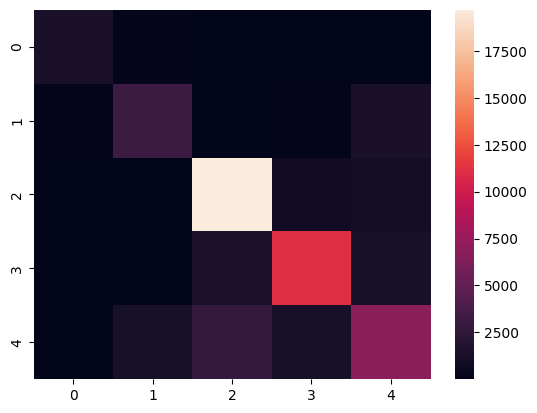

In [ ]:
sns.heatmap(cm)

In [ ]:
#@title Dokłądność  &nbsp;| &nbsp; *Accuracy*
np.sum(np.diag(cm))/np.sum(cm)

Array(0.7805895, dtype=float32)

### Czułość  &nbsp;| &nbsp; *Sensitivity*

Jaka część klazdej klasy została poprawnie przewidziana

*What proportion of each class has been correctly predicted*

In [ ]:
np.diag(cm)/np.sum(cm, axis=1)

Array([0.85590065, 0.651651  , 0.9141107 , 0.7979842 , 0.5648899 ],      dtype=float32)

#### Precyzja &nbsp;| &nbsp; *Precision*

Jaka z predykcji danej klasy była poprawna

*Which prediction of a given class was correct*

In [ ]:
np.diag(cm)/np.sum(cm, axis=0)

Array([0.85910225, 0.6780488 , 0.8235786 , 0.82962686, 0.6539862 ],      dtype=float32)